In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
from unicodedata import normalize
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from Bio import SeqIO, AlignIO, Phylo
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor

- Helper functions

In [3]:
def get_subtype(description: str) -> str:
    d = (description or "").upper()
    return "Alpha" if "ALPHA" in d else "NA"

def get_organism(description: str) -> str:
    # expects "... [Genus species]"
    try:
        org = description.split("[")[1].split("]")[0].strip().replace(" ", "-")
    except Exception:
        org = "NA"
    return org

def check_entries_to_ignore(description: str) -> bool:
    d = (description or "").lower()
    bad = ["hypothetical", "unnamed", "uncharacterized", "putative", "partial",
           "low quality", "fragment", "pseudogene"]
    return any(b in d for b in bad)

def prepare_sequences_for_MSA(dataset: pd.DataFrame, sequence_input: str, id_seq: str, name_export: str):
    records = []
    for _, row in dataset.iterrows():
        sequence = row["sequence"]
        acc = row["Accession"]
        parts = (row.get("Organism","NA") or "NA-NA").split("-")
        organism = f"{parts[0][0]}.-{parts[1]}" if len(parts) > 1 and parts[0] else parts[0]
        subtype = row.get("Subtype","NA")
        rec_id  = f"[{acc}]-{organism}|{subtype}"
        records.append(SeqRecord(Seq(sequence), id=rec_id, description=""))
    records.append(SeqRecord(Seq(sequence_input), id=id_seq, description=""))
    SeqIO.write(records, name_export, "fasta")

def run_msa(aligned_file: str, fasta_file: str):
    clustalomega_cline = ClustalOmegaCommandline(infile=fasta_file, outfile=aligned_file,
                                                 verbose=True, auto=True, force=True)
    print(f"Running MSA -> {aligned_file}")
    stdout, stderr = clustalomega_cline()

def plot_phylo_tree(aligned_file: str, out_svg: str, title: str = ""):
    alignment = AlignIO.read(aligned_file, "fasta")
    calculator = DistanceCalculator("blosum62")
    constructor = DistanceTreeConstructor()
    dm = calculator.get_distance(alignment)
    tree = constructor.nj(dm)

    # label colors: Alpha (red), A. purpuratus (green), others grey
    label_colors = {}
    for clade in tree.find_clades():
        if clade.name:
            n = clade.name
            if "A.purpuratus" in n or "A.purpuratus" in n.replace(" ","") or "A.purpuratus" in n.replace("-",""):
                label_colors[n] = "#136f63"
            elif n.endswith("|Alpha") or "|Alpha" in n:
                label_colors[n] = "#d00000"
            else:
                label_colors[n] = "#444444"

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(1,1,1)
    Phylo.draw(tree, do_show=False, axes=ax, label_colors=label_colors, show_confidence=False)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel("Branch length", fontsize=12)
    ax.set_ylabel("Taxa", fontsize=12)
    sns.despine()
    plt.tight_layout()
    fig.savefig(out_svg, dpi=300)
    plt.close(fig)

- Read BLAST hit table and **keep Alpha only**

In [4]:
# Load BLAST hit table
hits = pd.read_csv("../external_results_tools/4J6C457P013-Alignment-HitTable.csv", header=None)
hits.columns = ["query", "Accession", "Identity", "Coverage", "Mismatches", "Gaps",
                "Q_Start", "Q_End", "S_Start", "S_End", "E-value", "Max-Score", "-", "Frame", "--"]
hits = hits.drop(columns=["query", "Mismatches", "Gaps", "Max-Score", "-", "Q_Start", "Q_End", "S_Start", "S_End", "--"])

# subject sequences + descriptions
seqdump = []
for rec in SeqIO.parse("../external_results_tools/seqdump.txt", "fasta"):
    seqdump.append({"id_sequence": rec.id, "sequence": str(rec.seq), "description": rec.description})
fasta_df = pd.DataFrame(seqdump)

# Merge in sequence + description
df = hits.merge(fasta_df, left_on="Accession", right_on="id_sequence", how="left")

# Aux columns
df["to_ignore"] = df["description"].apply(check_entries_to_ignore)
df = df[df["to_ignore"] == False].copy()
df["Organism"] = df["description"].apply(get_organism)
df["Subtype"]  = df["description"].apply(get_subtype)

# ====== FILTER TO ALPHA ONLY ======
df = df[df["Subtype"] == "Alpha"].copy()

# Split by frame (matching original workflow; frames -2 and -3)
df_f2 = df[df["Frame"] == -2].copy()
df_f3 = df[df["Frame"] == -3].copy()

print("After Alpha filter → Frame2:", df_f2.shape, "Frame3:", df_f3.shape)

After Alpha filter → Frame2: (64, 11) Frame3: (64, 11)


- (Optional) QC plots (Alpha-only)

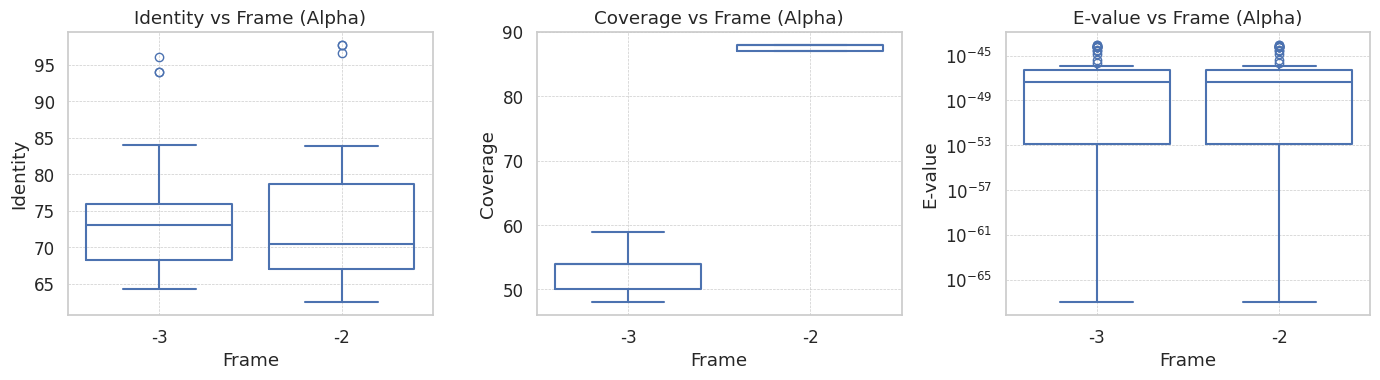

In [5]:
sns.set(style="whitegrid", context="notebook", font_scale=1.1)
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
sns.boxplot(data=df, x="Frame", y="Identity", ax=axes[0], fill=False)
axes[0].set_title("Identity vs Frame (Alpha)")
sns.boxplot(data=df, x="Frame", y="Coverage", ax=axes[1], fill=False)
axes[1].set_title("Coverage vs Frame (Alpha)")
sns.boxplot(data=df, x="Frame", y="E-value", ax=axes[2], fill=False)
axes[2].set_yscale("log"); axes[2].set_title("E-value vs Frame (Alpha)")
for ax in axes: ax.grid(True, linestyle="--", linewidth=0.5)
plt.tight_layout(); plt.show()

- Apply numeric filters (same thresholds as original)

In [6]:
# Keep your original cutoffs
f3 = df_f3[(df_f3["Identity"] >= 72.9) & (df_f3["Coverage"] >= 51.75)].copy()
f2 = df_f2[(df_f2["Identity"] >= 74.4) & (df_f2["Coverage"] >= 87.73)].copy()
print("Selected (Alpha) — Frame3:", f3.shape, "| Frame2:", f2.shape)

Selected (Alpha) — Frame3: (7, 11) | Frame2: (6, 11)


- Load translated frames for *A. purpuratus* and build FASTA (Alpha-only sets)

In [7]:


translated = []
for rec in SeqIO.parse("../external_results_tools/translate.txt", "fasta"):
    translated.append({"id_sequence": rec.id, "sequence": str(rec.seq), "description": rec.description})
df_translate = pd.DataFrame(translated)

def norm_text(s):
    return normalize("NFKC", str(s)).replace("’", "'").strip()

df_translate["id_sequence"] = df_translate["id_sequence"].map(norm_text)
df_translate["description"] = df_translate["description"].map(norm_text)

df_translate["frame_num"] = (
    df_translate["description"]
    .str.extract(r"Frame\s*([-+]?\d+)", expand=False)
    .astype("Int64")  
)

cand = df_translate[df_translate["id_sequence"].isin(["3'5'", "5'3'"])].copy()

cand = cand[cand["frame_num"] != 1]

def get_seq_for_frame(cand_df: pd.DataFrame, frame: int) -> str:
    # 1) intenta en 3'5'
    sub = cand_df[(cand_df["id_sequence"] == "3'5'") & (cand_df["frame_num"] == frame)]
    if len(sub):
        return sub.iloc[0]["sequence"]
    # 2) intenta en 5'3'
    sub = cand_df[(cand_df["id_sequence"] == "5'3'") & (cand_df["frame_num"] == frame)]
    if len(sub):
        return sub.iloc[0]["sequence"]
    sub = cand_df[cand_df["frame_num"] == frame]
    if len(sub):
        return sub.iloc[0]["sequence"]
    raise ValueError(
        f"No encontré secuencia para Frame {frame}. "
        f"Entradas disponibles:\n{cand_df[['id_sequence','description','frame_num']].to_string(index=False)}"
    )

seq_frame2 = get_seq_for_frame(cand, 2)
seq_frame3 = get_seq_for_frame(cand, 3)

prepare_sequences_for_MSA(f2, seq_frame2, "A.purpuratus", "../tmp/frame2.fasta")
prepare_sequences_for_MSA(f3, seq_frame3, "A.purpuratus", "../tmp/frame3.fasta")

print("FASTA written:", "../tmp/frame2.fasta", "../tmp/frame3.fasta")

FASTA written: ../tmp/frame2.fasta ../tmp/frame3.fasta


- Run MSA (Clustal Omega)

In [8]:
run_msa("../tmp/aligned_frame2.fasta", "../tmp/frame2.fasta")
run_msa("../tmp/aligned_frame3.fasta", "../tmp/frame3.fasta")

Running MSA -> ../tmp/aligned_frame2.fasta
Running MSA -> ../tmp/aligned_frame3.fasta


- Plot Neighbor-Joining trees (Alpha-only datasets)

In [9]:
plot_phylo_tree("../tmp/aligned_frame2.fasta", "../figures_paper/phylogenetic_tree_frame2.svg", title="Frame 2 — Alpha only")
plot_phylo_tree("../tmp/aligned_frame3.fasta", "../figures_paper/phylogenetic_tree_frame3.svg", title="Frame 3 — Alpha only")
print("Saved SVGs in ../figures_paper/")

Saved SVGs in ../figures_paper/
